In [24]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/FP-KK/dataset/train_baseline.csv'
dataset = pd.read_csv(dataset_path, encoding= 'unicode_escape')
dataset.shape

(839815, 6)

In [27]:
dataset.drop(['Unnamed: 0'], inplace=True, axis=1)
dataset

,Sentence #,Word,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,O,28285,14
1,Sentence: 1,of,O,15741,14
2,Sentence: 1,demonstrators,O,1523,14
3,Sentence: 1,have,O,367,14
4,Sentence: 1,marched,O,13632,14
...,...,...,...,...,...
839810,Sentence: 44529,as,O,21619,14
839811,Sentence: 44529,alternatives,O,21279,14
839812,Sentence: 44529,to,O,34610,14
839813,Sentence: 44529,oil,O,23416,14


In [28]:
dataset["Tag"].value_counts()

O        711029
B-geo     30162
B-tim     16251
B-org     16125
I-per     13917
B-per     13667
I-org     13583
B-gpe     12492
I-geo      5959
I-tim      5269
B-art       319
I-art       252
B-eve       240
I-eve       200
B-nat       162
I-gpe       154
I-nat        34
Name: Tag, dtype: int64

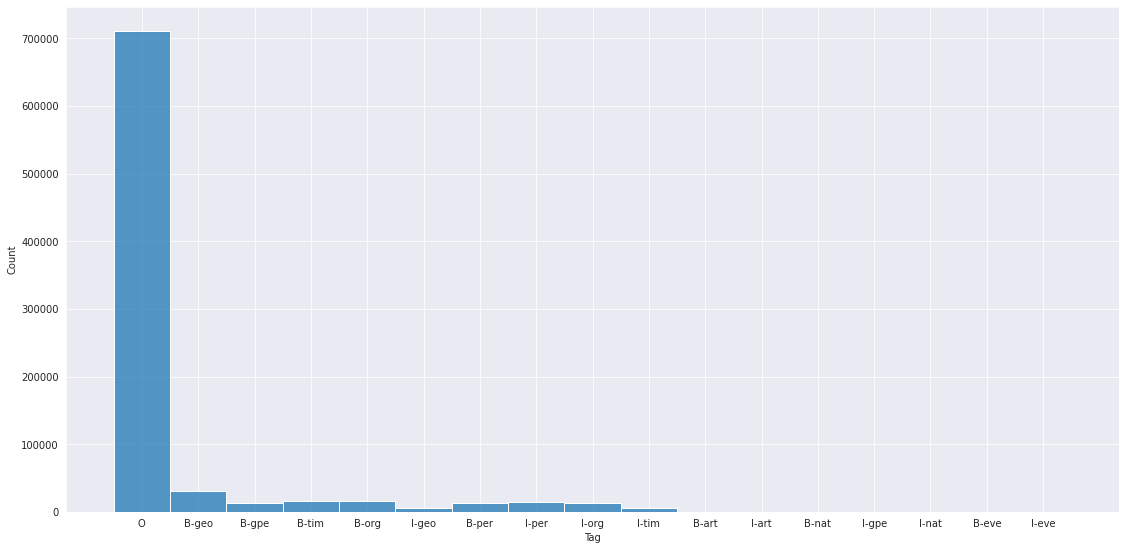

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (16,8))
sns.set_style('darkgrid')
sns.histplot(dataset['Tag'])
plt.tight_layout(pad=2)
plt.show()

In [30]:
dataset_fillna = dataset.fillna(method='ffill', axis=0)
dataset_group = dataset_fillna.groupby(['Sentence #'], as_index=False)['Word', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [31]:
dataset_group

,Sentence #,Word,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[28285, 15741, 1523, 367, 13632, 7168, 25967, ...","[14, 14, 14, 14, 14, 14, 6, 14, 14, 14, 14, 14..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[34424, 1990, 32928, 9794, 31792, 34610, 15641...","[7, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[28347, 29190, 19208, 2838, 24041, 26531, 7258...","[14, 14, 16, 14, 14, 14, 14, 14, 6, 14, 14, 14..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[O, O, O, O, O, O, O, O, O, O, O]","[4139, 30932, 1336, 28550, 18536, 21258, 26975...","[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[30896, 25325, 14734, 12754, 18505, 433, 7325,...","[6, 14, 14, 4, 5, 14, 16, 14, 6, 14, 7, 14, 7,..."
...,...,...,...,...,...
38363,Sentence: 44525,"[President, Bush, called, on, the, United, Sta...","[B-per, I-per, O, O, O, B-geo, I-geo, O, O, O,...","[344, 19638, 28590, 29279, 3894, 18510, 6565, ...","[4, 5, 14, 14, 14, 6, 0, 14, 14, 14, 14, 14, 1..."
38364,Sentence: 44526,"[Mr., Bush, said, dependence, on, foreign, sou...","[B-per, I-per, O, O, O, O, O, O, O, O, B-geo, ...","[188, 19638, 433, 7527, 29279, 11236, 5495, 15...","[4, 5, 14, 14, 14, 14, 14, 14, 14, 14, 6, 14, ..."
38365,Sentence: 44527,"[The, president, called, for, reducing, gasoli...","[O, O, O, O, O, O, O, O, O, B-geo, O, O, O, B-...","[20005, 3610, 28590, 12209, 28521, 30306, 3119...","[14, 14, 14, 14, 14, 14, 14, 14, 14, 6, 14, 14..."
38366,Sentence: 44528,"[He, said, the, goal, can, be, met, by, increa...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[22908, 433, 3894, 32462, 14067, 26107, 19184,...","[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 1..."


Membuat list data kandidat yang akan digunakan saat melakukan oversampling. Data-data ini diambil secara acak dari dataset awal, sehingga metode ini mengandung unsur random oversampling pada sisi pengambilan kandidat data yang akan dibangkitkan

In [32]:
geoList = ["States", "City", "Province", "Islands", "Republic"]
orgList = ["Agency", "Council", "Association", "Company", "Community", "Committee", "Department", "Organization"]
perList = ["Pinochet", "Montiglio", "George", "Laurent", "Levy", "Abbas", "Felipe", "Sharon", "Ariel", "Lavrov", "Bush", "Silva", "Putin", "Chavez", "Rosales", "Howard", "Bashar", "Nahles", "Johnson", "Morris", "Davis", "Robert", "Karzai", "Jalal"]

In [33]:
import random
def generateRandomEntity(entityType):
  if(entityType == 'GEO'):
    return random.choice(geoList)
  elif(entityType == 'ORG'):
    return random.choice(orgList)
  else:
    return random.choice(perList)

Load dictionary dari hasil preprocessing untuk memetakan token2idx dan sebaliknya serta tag2idx dan sebaliknya.

In [34]:
# importing the module
import json
 
# Opening JSON file
def loadJSON(filename):
  data = {}
  with open(filename) as json_file:
      data = json.load(json_file)
  return data

In [35]:
idx2tag = loadJSON('/content/drive/MyDrive/Colab Notebooks/FP-KK/output/idx2tag.json')
tag2idx = loadJSON('/content/drive/MyDrive/Colab Notebooks/FP-KK/output/tag2idx.json')
token2idx = loadJSON('/content/drive/MyDrive/Colab Notebooks/FP-KK/output/token2idx.json')
idx2token = loadJSON('/content/drive/MyDrive/Colab Notebooks/FP-KK/output/idx2token.json')
print(idx2tag)

{'0': 'I-geo', '1': 'I-org', '2': 'B-nat', '3': 'I-eve', '4': 'B-per', '5': 'I-per', '6': 'B-geo', '7': 'B-gpe', '8': 'B-eve', '9': 'I-art', '10': 'B-org', '11': 'I-tim', '12': 'B-art', '13': 'I-gpe', '14': 'O', '15': 'I-nat', '16': 'B-tim'}


In [36]:
def oversample(data):
  for sentenceIdx in range(0, data.shape[0]):
    last = False
    for tagIdx in range(0, len(data.loc[sentenceIdx, 'Tag'])):
      if(tagIdx == len(data.loc[sentenceIdx, 'Tag']) - 1):
        last = True
      # Oversampling process
      if((data.loc[sentenceIdx, 'Tag'][tagIdx] == 'B-geo' and last == True) or (data.loc[sentenceIdx, 'Tag'][tagIdx] == 'B-geo' and data.loc[sentenceIdx, 'Tag'][tagIdx + 1] == 'O')):
        random_word = generateRandomEntity('GEO')
        data.loc[sentenceIdx, 'Word'].insert(tagIdx + 1, random_word)
        data.loc[sentenceIdx, 'Word_idx'].insert(tagIdx + 1, token2idx.get(random_word))
        data.loc[sentenceIdx, 'Tag'].insert(tagIdx + 1, 'I-geo')
        data.loc[sentenceIdx, 'Tag_idx'].insert(tagIdx + 1, tag2idx.get('I-geo'))
      elif((data.loc[sentenceIdx, 'Tag'][tagIdx] == 'B-org' and last == True) or (data.loc[sentenceIdx, 'Tag'][tagIdx] == 'B-org' and data.loc[sentenceIdx, 'Tag'][tagIdx + 1] == 'O')):
        random_word = generateRandomEntity('ORG')
        data.loc[sentenceIdx, 'Word'].insert(tagIdx + 1, random_word)
        data.loc[sentenceIdx, 'Word_idx'].insert(tagIdx + 1, token2idx.get(random_word))
        data.loc[sentenceIdx, 'Tag'].insert(tagIdx + 1, 'I-org')
        data.loc[sentenceIdx, 'Tag_idx'].insert(tagIdx + 1, tag2idx.get('I-org'))
      elif((data.loc[sentenceIdx, 'Tag'][tagIdx] == 'B-per' and last == True) or (data.loc[sentenceIdx, 'Tag'][tagIdx] == 'B-per' and data.loc[sentenceIdx, 'Tag'][tagIdx + 1] == 'O')):
        random_word = generateRandomEntity('PER')
        data.loc[sentenceIdx, 'Word'].insert(tagIdx + 1, random_word)
        data.loc[sentenceIdx, 'Word_idx'].insert(tagIdx + 1, token2idx.get(random_word))
        data.loc[sentenceIdx, 'Tag'].insert(tagIdx + 1, 'I-per')
        data.loc[sentenceIdx, 'Tag_idx'].insert(tagIdx + 1, tag2idx.get('I-per'))

  return data

In [37]:
def nerOversample2(dataset):
  for sentence in range(0, dataset.shape[0]):
    last = False
    word_num = len(dataset.loc[sentence, 'Word'])
    for tag in range(0, word_num):
      if (tag == word_num - 1):
        last = True
      # Oversampling process
      if((dataset.loc[sentence, 'Tag'][tag] == 'B-geo' and last == True) or (dataset.loc[sentence, 'Tag'][tag] == 'B-geo' and dataset.loc[sentence, 'Tag'][tag+1] == 'O')):
        word = dataset.loc[sentence, 'Word'][tag]
        dataset.loc[sentence, 'Word'].insert(word_num - 1, word)
        dataset.loc[sentence, 'Word_idx'].insert(word_num - 1, token2idx.get(word))
        dataset.loc[sentence, 'Tag'].insert(word_num - 1, 'B-geo')
        dataset.loc[sentence, 'Tag_idx'].insert(word_num - 1, tag2idx.get('B-geo'))
      elif((dataset.loc[sentence, 'Tag'][tag] == 'B-org' and last == True) or (dataset.loc[sentence, 'Tag'][tag] == 'B-org' and dataset.loc[sentence, 'Tag'][tag+1] == 'O')):
        random_word = generateRandomEntity('ORG')
        dataset.loc[sentence, 'Word'].insert(tag+1, random_word)
        dataset.loc[sentence, 'Word_idx'].insert(tag+1, token2idx.get(random_word))
        dataset.loc[sentence, 'Tag'].insert(tag+1, 'I-org')
        dataset.loc[sentence, 'Tag_idx'].insert(tag+1, tag2idx.get('I-org'))
      elif((dataset.loc[sentence, 'Tag'][tag] == 'B-per' and last == True) or (dataset.loc[sentence, 'Tag'][tag] == 'B-per' and dataset.loc[sentence, 'Tag'][tag+1] == 'O')):
        random_word = generateRandomEntity('PER')
        dataset.loc[sentence, 'Word'].insert(tag+1, random_word)
        dataset.loc[sentence, 'Word_idx'].insert(tag+1, token2idx.get(random_word))
        dataset.loc[sentence, 'Tag'].insert(tag+1, 'I-per')
        dataset.loc[sentence, 'Tag_idx'].insert(tag+1, tag2idx.get('I-per'))
  return dataset

Backup dataset sebelum melakukan oversampling

In [38]:
data_backup = dataset_group.copy()
dataset_untuk_sample = data_backup.copy()

In [39]:
data_backup

,Sentence #,Word,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[28285, 15741, 1523, 367, 13632, 7168, 25967, ...","[14, 14, 14, 14, 14, 14, 6, 14, 14, 14, 14, 14..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[34424, 1990, 32928, 9794, 31792, 34610, 15641...","[7, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[28347, 29190, 19208, 2838, 24041, 26531, 7258...","[14, 14, 16, 14, 14, 14, 14, 14, 6, 14, 14, 14..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[O, O, O, O, O, O, O, O, O, O, O]","[4139, 30932, 1336, 28550, 18536, 21258, 26975...","[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[30896, 25325, 14734, 12754, 18505, 433, 7325,...","[6, 14, 14, 4, 5, 14, 16, 14, 6, 14, 7, 14, 7,..."
...,...,...,...,...,...
38363,Sentence: 44525,"[President, Bush, called, on, the, United, Sta...","[B-per, I-per, O, O, O, B-geo, I-geo, O, O, O,...","[344, 19638, 28590, 29279, 3894, 18510, 6565, ...","[4, 5, 14, 14, 14, 6, 0, 14, 14, 14, 14, 14, 1..."
38364,Sentence: 44526,"[Mr., Bush, said, dependence, on, foreign, sou...","[B-per, I-per, O, O, O, O, O, O, O, O, B-geo, ...","[188, 19638, 433, 7527, 29279, 11236, 5495, 15...","[4, 5, 14, 14, 14, 14, 14, 14, 14, 14, 6, 14, ..."
38365,Sentence: 44527,"[The, president, called, for, reducing, gasoli...","[O, O, O, O, O, O, O, O, O, B-geo, O, O, O, B-...","[20005, 3610, 28590, 12209, 28521, 30306, 3119...","[14, 14, 14, 14, 14, 14, 14, 14, 14, 6, 14, 14..."
38366,Sentence: 44528,"[He, said, the, goal, can, be, met, by, increa...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[22908, 433, 3894, 32462, 14067, 26107, 19184,...","[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 1..."


In [40]:
data_backup.loc[2, 'Word'][8]

'Orakzai'

In [41]:
dataset_sampled = nerOversample2(dataset_untuk_sample)

In [42]:
dataset_sampled

,Sentence #,Word,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[28285, 15741, 1523, 367, 13632, 7168, 25967, ...","[14, 14, 14, 14, 14, 14, 6, 14, 14, 14, 14, 14..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[34424, 1990, 32928, 9794, 31792, 34610, 15641...","[7, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[28347, 29190, 19208, 2838, 24041, 26531, 7258...","[14, 14, 16, 14, 14, 14, 14, 14, 6, 14, 14, 14..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[O, O, O, O, O, O, O, O, O, O, O]","[4139, 30932, 1336, 28550, 18536, 21258, 26975...","[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[30896, 25325, 14734, 12754, 18505, 433, 7325,...","[6, 14, 14, 4, 5, 14, 16, 14, 6, 14, 7, 14, 7,..."
...,...,...,...,...,...
38363,Sentence: 44525,"[President, Bush, called, on, the, United, Sta...","[B-per, I-per, O, O, O, B-geo, I-geo, O, O, O,...","[344, 19638, 28590, 29279, 3894, 18510, 6565, ...","[4, 5, 14, 14, 14, 6, 0, 14, 14, 14, 14, 14, 1..."
38364,Sentence: 44526,"[Mr., Bush, said, dependence, on, foreign, sou...","[B-per, I-per, O, O, O, O, O, O, O, O, B-geo, ...","[188, 19638, 433, 7527, 29279, 11236, 5495, 15...","[4, 5, 14, 14, 14, 14, 14, 14, 14, 14, 6, 14, ..."
38365,Sentence: 44527,"[The, president, called, for, reducing, gasoli...","[O, O, O, O, O, O, O, O, O, B-geo, O, O, O, B-...","[20005, 3610, 28590, 12209, 28521, 30306, 3119...","[14, 14, 14, 14, 14, 14, 14, 14, 14, 6, 14, 14..."
38366,Sentence: 44528,"[He, said, the, goal, can, be, met, by, increa...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[22908, 433, 3894, 32462, 14067, 26107, 19184,...","[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 1..."


Kembalikan dataframe untuk melihat hasil oversampling

In [43]:
def buildDataFrame(groupedData):
  word_list = []
  tag_list = []
  sentence_list = []
  word_idx = []
  tag_idx = []
  for sentence in range(0, groupedData.shape[0]):
    sentence_array = [groupedData.loc[sentence, 'Sentence #']] * len(groupedData.loc[sentence, 'Word'])
    sentence_list = sentence_list + sentence_array
    word_list = word_list + groupedData.loc[sentence, 'Word']
    tag_list = tag_list + groupedData.loc[sentence, 'Tag']
    word_idx = word_idx + groupedData.loc[sentence, 'Word_idx']
    tag_idx = tag_idx + groupedData.loc[sentence, 'Tag_idx']
    # print(sentence, len(sentence_list), len(word_list), len(tag_list), len(word_idx), len(tag_idx))
    # dataFrameLoop = pd.DataFrame({'Sentence #': sentence_list, 'Word': word_list, 'Tag': tag_list, 'Word_idx': word_idx, 'Tag_idx': tag_idx})
    # dataFrame = dataFrame.append([dataFrameLoop])
    # print(sentence_list, word_list, tag_list)
  dataFrame = pd.DataFrame({'Sentence #': sentence_list, 'Word': word_list, 'Tag': tag_list, 'Word_idx': word_idx, 'Tag_idx': tag_idx})
  # return sentence_list, word_list, tag_list
  return dataFrame

In [44]:
train_df_after_sampling =  buildDataFrame(dataset_sampled)

In [45]:
train_df_after_sampling["Tag"].value_counts()

O        711029
B-geo     67438
I-org     21377
I-per     16853
B-tim     16251
B-org     16125
B-per     13667
B-gpe     12492
I-geo      5959
I-tim      5269
B-art       319
I-art       252
B-eve       240
I-eve       200
B-nat       162
I-gpe       154
I-nat        34
Name: Tag, dtype: int64

In [46]:
train_df_after_sampling.to_csv('/content/drive/MyDrive/Colab Notebooks/FP-KK/dataset/train_nerOversampled2.csv')